# **Case study**: Farrell zebrafish embryo data

Here we provide instructions and code to reproduce a case study from our paper, focused on a **[zebrafish embryo scRNA-seq dataset](https://singlecell.broadinstitute.org/single_cell/study/SCP162/single-cell-reconstruction-of-developmental-trajectories-during-zebrafish-embryogenesis)** from [*Farell et al. (2018)*](https://www.science.org/doi/10.1126/science.aar3131):

* Farrell JA, Wang Y, Riesenfeld SJ, et al (2018) Single-cell reconstruction of developmental trajectories during zebrafish embryogenesis. Science 360. https://doi.org/10.1126/science.aar3131

In this notebook, we...

* evaluate the capacity of 6 dimensionality reduction (DR) methods **to faithfully embed known high-dimensional structures in the data in low dimension**;
* analyse local embedding distortions by encoder-based DR models using **encoder indicatrices**;
* provide code to generate relevant figures from our paper;
* provide code for exploration of differential gene expression with the use of low-dimensional embeddings.

Please note that **R is needed** at one point to extract some metadata provided by the study authors.

<br>
<details>
<summary><b>Why we chose this dataset</b></summary>

Low-dimensional embeddings are commonly assessed by their **ability to separate cell subtypes that are understood to be distinct populations**.
This is often done successfully by optimising preservation of local structure in embeddings.

However, many single-cell atlases now contain large amounts of data with **non-local structures corresponding to developmental trends**.
Even multi-organ and logitudinal models of development at a single-cell level now exist (with relevance to embrology and immunology).

Specifically, the *Farrell* dataset is published alongside a study into the **differentiation of various cell lineages in zebrafish embryos**.
Transcriptomic samples from 694 embryos were measured across **different time points**, from early progenitor cells at 3.3 hours post-fertilisation (*hpf*) up to more clearly differentiated cells at 12 *hpf*.

Futhermore, the authors provide **cell lineage labels**, along with corresponding **pseudotime values per cell** (*i.e.*, cell-level progression along a developmental pathway).

The presence of both a **temporal component** (*i.e.*, the *hpf* stages) and a **pseudotemporal component** (*i.e.*, developmental pseudotime values assigned per cell) is key for our case study.
This is because they represent different developmental processes that come with **different assumptions**:

* **Temporal** development: transitions between *hpf* (time-point) stages can reasonably be expected to be **discontinuous** (*i.e.*, show abrupt changes in expression profile or a representation thereof between cells).
* **Pseudotemporal** development: transitions between consecutive cells along a developmental continuum are expected to be **gradual**, unless crossing between *hpf* stages.

The assumption of gradual changes along pseudotime is widely-used in the trajectory inference field (see the [Wanderlust paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC4045247/) for an early formulation of it).

**Hence, a faithful embedding of this dataset should preserve both discontinuous and continuous transitions where they occur.**

Methods which are biased towards clear separation of clusters may distort continuous transitions, whereas smoother embeddings may distort the discontinuous transitions.
Therefore, the Farrell dataset is an example where the trade-off between these two criteria in generating embeddings is clearly desirable.

<hr>
</details>
<br>

<details>
<summary><b>Which methods we compare and why</b></summary>

We compare 6 algorithms, chosen to demonstrate differences between 3 families of DR methods:

* **Neighbour embedding (NE)**:
    - *t*-SNE: tends to preserve small local structures and separate cell populations in single-cell data well
    - *UMAP*: strikes a favourable local-versus-global structure preservation balance in numerous use-cases
* **Multi-dimensional scaling (MDS)**:
    - *SQuad-MDS*: is biased toward high preservation of global structures due to a scale-agnostic embedding procedure
* **Variational autoencoder (VAE)** and its adaptations:
    - (vanilla) VAE: learns a smooth and parametric transformation, often with local distortions of the latent space
    - *ViVAE*: uses denoising and stochastic-MDS regularisation to yield a less distorted and less noisy version of a VAE embedding
    - *ViVAE-EncoderOnly*: simpler and faster decoder-less adaptation of the *ViVAE* model with a slightly smoother but noisier latent space

While NE approaches tend to favour separation of distinct clusters, MDS and VAE-based approaches generally favour smoother embeddings, better suited to represent global structures and developmental gradients.

Note that *ViVAE* incorporates a **denoising component** and **MDS-based regularisation** into a VAE-based model.
This is an effort to boost **robustness against noise** and **reduce the tendency of autoencoders and variational autoencoders to introduce distortions in their latent space**.

Our paper introduces **encoder indicatrices** for detection of local distortions in VAE-based models.
a standard variational autoencoder (VAE), default ViVAE and a ViVAE encoder-only (parametric MDS-like) model.
To this end, we plot **encoder indicatrices** to show local distortions of each model's latent space.

</details>
<br><hr>

## **0.** Load required modules

To run this notebook, install `vivae`, `viscore`, `umap` and `SQuadMDS` into your Python environment.
In terminal:

```bash
pip install git+https://github.com/saeyslab/ViVAE
pip install git+https://github.com/saeyslab/ViScore
pip install git+https://github.com/davnovak/SQuad-MDS
pip install umap-learn
```

Then load all required modules as shown below...

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os, numpy as np, pandas as pd, colorsys, math, matplotlib as mpl, matplotlib.pyplot as plt

os.environ['VIVAE_DETERMINISTIC'] = '1'
os.environ['VIVAE_CUDA'] = '0'
os.environ['VIVAE_MPS'] = '0'

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import torch
import vivae as vv
import viscore as vs
from sklearn.manifold import TSNE
from umap import UMAP
from SQuadMDS import SQuadMDS
from sklearn.manifold import TSNE
from matplotlib.patches import Rectangle

INFO:vivae:initialised with "cpu" backend and determinism enabled


## **1.** Load input data

We provide **instructions for downloading and pre-processing the data** in the `benchmarking` documentation of the [ViScore](https://github.com/saeyslab/ViScore) GitHub repository.
Once that is done, import the required inputs...

In [2]:
## Assume inputs are saved in ../data

pc   = np.load(os.path.join('..', 'data', 'Farrell_input.npy'),          allow_pickle=True) # 100 PCs
pc_d = np.load(os.path.join('..', 'data', 'Farrell_input_denoised.npy'), allow_pickle=True) # 100 PCs denoised
labs = np.load(os.path.join('..', 'data', 'Farrell_labels.npy'),         allow_pickle=True) # developmental stage labels
knn  = np.load(os.path.join('..', 'data', 'Farrell_knn.npy'),            allow_pickle=True) # k-nearest-neighbour graph

As mentioned, the study authors provide **metadata** that further describes cell development.
To obtain it, download the `URD_Zebrafish_Object.rds` file from the [Single Cell Portal page](https://singlecell.broadinstitute.org/single_cell/study/SCP162/single-cell-reconstruction-of-developmental-trajectories-during-zebrafish-embryogenesis) and move it to your working directory.

Once that is done, expand the block below and run the code in R.

<details>
<summary><b>Extraction of metadata in R</b></summary>

```R
## Install and load URD: the authors' trajectory inference tool ----
devtools::install_github('farrellja/URD')
library(URD)

## Install and load reticulate: for interfacing with Python ----
install.packages('reticulate') # for troubleshooting: https://rstudio.github.io/reticulate/
library(reticulate)
np <- import('numpy')

## Load URD analysis object ----
x  <- readRDS('URD_Zebrafish_Object.rds')

## Extract pseudotime ----
ps <- x@tree$pseudotime
if (all(names(ps)==meta$NAME[-1])) message('Cell names are correctly aligned')
np$save('../data/Farrell_URD_pseudotime.npy', ps, allow_pickle = TRUE)

## Extract expression of a gene of interest (scaled) ----
g <- 'NANOS3' # gene of interest
np$save(paste0('../data/Farrell_exprs_', g, '.npy'), exprs[g, , drop = TRUE], allow_pickle = TRUE)
```

<hr>
</details>

Then we can proceed to load the metadata in Python...

In [3]:
meta        = pd.read_csv('../data/Farrell_meta.txt', sep='\t')                # this is the `URD_Dropseq_Meta.txt` file from Single Cell Portal
ps          = np.load('../data/Farrell_URD_pseudotime.npy', allow_pickle=True) # URD pseudotime values per cell
expr_nanos3 = np.load('../data/Farrell_exprs_NANOS3.npy', allow_pickle=True)   # expression values of NANOS3

## **2.** Generate embeddings

Let's generate our embeddings using the PCA-transformed expression data.
Note that we use denoised inputs for *ViVAE* and *ViVAE-EncoderOnly*.
See our paper for a full ablation study of the effects of denoising with all other tested DR methods.

In [4]:
print('Generating t-SNE embedding')
emb_tsne = TSNE(n_components=2, random_state=42).fit_transform(pc)
np.save('emb_Farrell_tsne.npy', emb_tsne, allow_pickle=True)

print('Generating UMAP embedding')
emb_umap = UMAP(n_components=2, random_state=42).fit_transform(pc)
np.save('emb_Farrell_umap.npy', emb_umap, allow_pickle=True)

print('Generating SQuad-MDS embedding')
emb_squadmds = SQuadMDS(n_components=2, random_state=42).fit_transform(pc)
np.save('emb_Farrell_squadmds.npy', emb_squadmds, allow_pickle=True)

print('Generating VAE embedding')
torch.manual_seed(42)
np.random.seed(42)
model_vae = vv.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vae.fit(pc, lam_recon=1., lam_kldiv=1., lam_mds=0., verbose=False)
emb_vae = model_vae.transform(pc)
np.save('emb_Farrell_vae.npy', emb_vae, allow_pickle=True)

print('Generating ViVAE-EncoderOnly embedding')
torch.manual_seed(42)
np.random.seed(42)
model_vivae_enconly = vv.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vivae_enconly.fit(pc_d, lam_recon=0., lam_kldiv=1., lam_mds=100., verbose=False)
emb_vivae_enconly = model_vivae_enconly.transform(pc_d)
np.save('emb_Farrell_vivae_enconly.npy', emb_vivae_enconly, allow_pickle=True)

print('Generating ViVAE embedding')
torch.manual_seed(42)
np.random.seed(42)
model_vivae = vv.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
model_vivae.fit(pc_d, lam_recon=1., lam_kldiv=1., lam_mds=100., verbose=False)
emb_vivae = model_vivae.transform(pc_d)
np.save('emb_Farrell_vivae.npy', emb_vivae, allow_pickle=True)

Generating t-SNE embedding
Generating UMAP embedding


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating SQuad-MDS embedding
Generating VAE embedding
Generating ViVAE-EncoderOnly embedding
Generating ViVAE embedding


## **3.** Plot embeddings with *hpf*-stage labels

Let's generate a figure with all 6 embeddings of the data side-by-side, with cell labels by *hpf* stage.
We use a rainbow colour scheme to indicate temporal progression within each embedding.

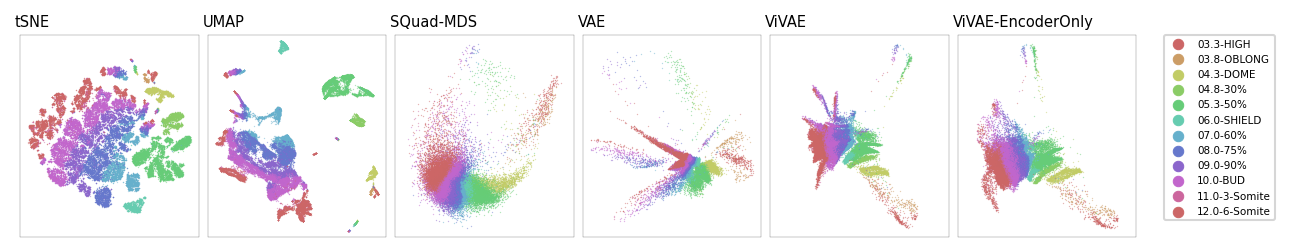

In [5]:
def rainbow(n, saturation=.5, brightness=.8):
    """Generate a rainbow palette of `n` colors"""
    hsv = [(h, saturation, brightness) for h in np.linspace(0, 1, n)]
    rgb = [colorsys.hsv_to_rgb(*h) for h in hsv]
    hex = ['#%02x%02x%02x' % (int(r[0]*255), int(r[1]*255), int(r[2]*255)) for r in rgb]
    return np.array(hex)

## Generate a palette of colours per hpf stage
palette = rainbow(len(np.unique(labs)))

## Get all unique hpf-stage labels
pops = np.unique(labs)

## Initialise a row of plots per embedding method
mpl.rcParams['axes.linewidth'] = 0.1
methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=nmet, figsize=(1.6*nmet, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
s = .01

## Plot embedding per method
for i, method in enumerate(methods):
    emb = embs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)
    ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax[i].axis('equal')
    ax[i].set_title(methods[i], size=7, ha='left', x=-.03, y=.98)
    
    ## Plot legend for hpf labels
    if i==(len(methods)-1):
        l = fig.legend(bbox_to_anchor=(1., .9), fontsize=5, markerscale=50.)

## Save the figure
fig.savefig('Farrell_stages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_stages.svg', bbox_inches='tight', transparent=True)

## **4.** Inspect cell developmental lineages

Each labelled **developmental lineage** starts at early progenitors and transitions toward increasingly differentiated cells.
We want to see how different lineages map onto each embedding.

To that end, **we label each point (~cell) by its position within the lineage of interest** (*i.e.*, pseudotime rank).
Note that all cells from the *03.3-HIGH* stage were assigned a pseudotime value of zero (*i.e.*, no developmental gradient indicated within the 3.3-*hpf* subset).
Therefore, we assign them a tied rank of 0 here as well.

<hr>

We pick 6 clearly distinct lineages of interest here, **each tracking the development of a different anatomical structure**.
Their descriptions are below.

<details>
<summary><b>Lineages of interest</b></summary>

* **Notochord** lineage: the notochord is a cartilage-like structure crucial for support and development of the vertebral column.
* **Spinal cord** lineage: the spinal cord is a column of nerve tissue along the notochord.
* **Adaxial cells** lineage: adaxial cells are muscle precustsor cells that migrate away from the notochord as they differentiate to form specific types of muscle fiber tissues.
* **Enveloping layer** (EVL) lineage: EVL cells form an outer layer of the early zebrafish embryo which acts as a protective physical barrier.
* **Primordial germ cells** (PGC) lineage: PGCs are precursors to cells that ultimately develop into sperm or eggs.
* **Prechordal plage** lineage: prechordal plate cells organise the formation of head structures and development of the zebrafish body's midline.

<hr>
</details>
<br>

<details>
<summary><b>How to pick other lineages</b></summary>

To explore other labelled lineages, run:
```python
print('\n'.join([x.replace('Lineage_', '') for x in meta.columns[4:]]))
```
Then add any other lineages that interest you to the `lineages` list in the code cell below.

<hr>
</details>

Now let's compute the cell ranks per lineage of interest and scale them (linearly, to a $[0,1]$ range) so as to align them between lineages...

In [6]:
## Specify lineages of interest
lineages = ['Notochord', 'Spinal_Cord', 'Adaxial_Cells', 'EVL', 'Primordial_Germ_Cells', 'Prechordal_Plate']

## Initialise indices of cells within lineage and their ranks (scaled & unscaled)
cell_idcs = {}
cell_ranks = {}
cell_ranks_unscaled = {}

for lin in lineages:
    ## Indices of cells within lineage
    idcs = np.where([x in ['True', 'TRUE'] for x in meta[f'Lineage_{lin}'][1:]])[0]

    ## Their pseudotime values and hpf-stage labels
    lin_ps = ps[idcs]
    lin_labs = labs[idcs]

    ## Cell progress within lineage per cell
    order = np.argsort(lin_ps, kind='stable')
    idcs = idcs[order]
    progress = np.repeat(0., len(idcs))
    idcs_non_origin = np.where(lin_labs!='03.3-HIGH')[0] # assign 0 to each 03.3-hpf cells
    progress[idcs_non_origin] = np.linspace(start=0, stop=1, num=len(idcs_non_origin)+1)[1:]

    cell_idcs[lin] = idcs
    cell_ranks[lin] = progress

Finally, let's visualise our lineages of interest within each embedding.

To indicate progress within a lineage, **we will colour points (~cell embeddings) by pseudotime-derived labels** (as opposed to *hpf* stages).
Additionally, points with a rank value above 0.99 will be marked in red, in order to highlight the end-points of each lineage...

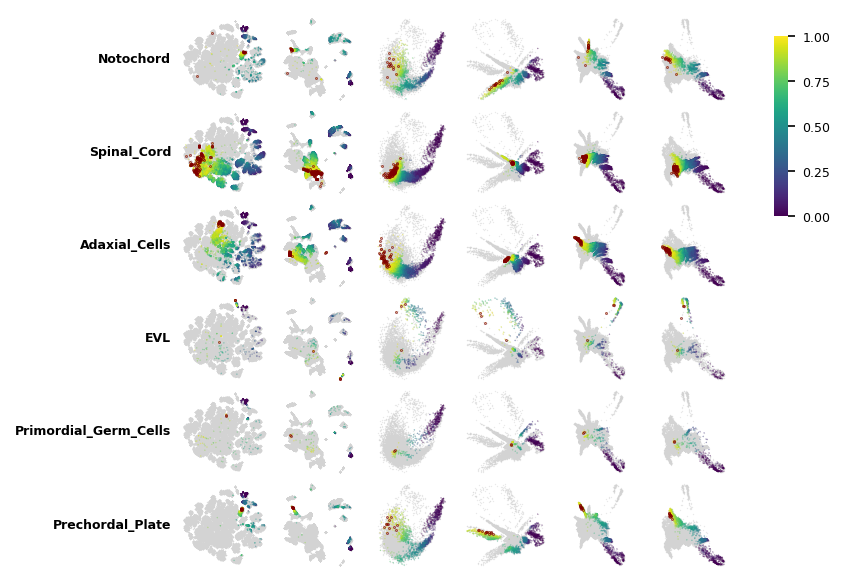

In [7]:
## Column per lineage of interest, row per embedding method
cols = lineages
ncol = len(cols)
methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)

## Initialise a grid of plots
fig, ax = plt.subplots(nrows=ncol, ncols=nmet, figsize=(.8*nmet, .8*ncol), dpi=150)
fig.subplots_adjust(wspace=.05, hspace=.05)
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
mpl.rcParams['axes.linewidth'] = 0.
for i, col in enumerate(cols):

    ## Raw indices and scaled rank values of cells within lineage
    idcs = cell_idcs[col]
    ranks = cell_ranks[col]

    ## Indices of terminal cells (top one percent of ranks)
    idcs_terminal = np.where(ranks>.99)[0]

    nmet = len(methods)
    handles = []
    labels = []

    for j, method in enumerate(methods):
        emb = embs[j]

        ## Plot whole embedding in background
        ax[i][j].scatter(emb[:,0], emb[:,1], s=.01, c='lightgrey', linewidth=.5)

        ## Plot cells in lineage using a colour gradient
        ax[i][j].scatter(emb[idcs,0], emb[idcs,1], s=.01, c=ranks, linewidth=.5, cmap='viridis')

        ## Highlight terminal cells
        ax[i][j].scatter(emb[idcs[idcs_terminal],0], emb[idcs[idcs_terminal],1], s=.08, edgecolors='face', c='maroon', linewidth=1.)

        ax[i][j].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax[i][j].axis('equal')
        for spine in ax[i][j].spines.values():
            spine.set_edgecolor('none')
        
        ## Display a colour bar for cell rank values
        if i==0 and j==(len(methods)-1):
            sm = mpl.cm.ScalarMappable(cmap='viridis')
            sm.set_array([0.,1.])
            cax = plt.axes([0.95, 0.6, 0.02, 0.25])
            cb = plt.colorbar(sm, cax=cax, location='right')
            for t in cb.ax.get_yticklabels():
                t.set_fontsize(6)

## Annotate rows with lineage names
for a, row in zip(ax[:,0], cols):
    a.annotate(row, xy=(0, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=6, weight='bold', ha='right', va='center')

## Save figure
fig.savefig('Farrell_lineages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_lineages.svg', bbox_inches='tight', transparent=True)

## **5.** Evaluate the faithfulness of lineage embeddings

Our unsupervised evaluation methodology lets us compare DR methods by how well they preserve local global structures in any single-cell data (see `help(vs.score)`).
Here we go further, leveraging the annotation of developmental pathways to answer the following:

*How faithfully is the development of cells represented by each embedding?*

We propose a framework to quantify this **per labelled lineage and per embedding**.
For details, expand the block below.

<details>
<summary><b>Preservation of relative transition distances (RTDs)</b></summary>

When ordered by pseudotime, the cells within a lineage go from 'less' to 'more' developed.
If we follow this sequence from beginning to end, each step along the way can be associated with a **transition between two cell representations**.
Instances of cell representations are expression levels of genes, a PCA-reduced representation thereof or a corresponding 2-dimensional embedding.

For each transition, we can calculate a **transition distance (TD)**: dissimilarity between the two points ($L^2$ distance between consecutive representations $\mathbf{c}_{i}$ and $\mathbf{c}_{j}$, $\tau_{i} \leq \tau_{j}$ where $\mathbf{\tau}$ is the vector of pseudotime values).

**These TDs quantify a relative rate at which the sequence of cells traverses the point cloud that represents our data.**
A large TD suggests a less continuous transition, and vice versa.

Given a representation of our data, we calculate TDs for **each lineage of interest** (yielding $n-1$ TDs for a lineage containing $n$ cells).
We scale them via $\mathrm{log1p}$-scaling to account for differences in magnitude between input data and embeddings, obtaining **relative transition distances (RTDs)**.

Recall that **our aim is to assess the fidelity of each embedding w.r.t. its input data and a chosen lineage**.
Therefore, we take the lineage-specifc sequence of RTDs in input space as the ground truth here.

The input-space RTDs need to be compared to those calculated for each embedding.
To that end, we take the **$L^{1}$-distance value between the aligned input-space and embedding RTD distributions** and apply *min-max* scaling for consistency between lineages with different cell counts.

This way we obtain a **measure of divergence from the RTDs in input space by each embedding method**.
A smaller divergence indicates a more faithful preservation of the lineage transitions.

<hr>
</details>

We provide a full implementation of this below...

In [8]:
def minmax(x):
    """Linear scaling of values to [0,1] range"""
    return (x-x.min())/(x.max()-x.min())

def compute_transitions(
        repre_names, repre_data, lineages, cell_idcs=cell_idcs
    ):
    """Compute transition distances
    
    Args:
        repre_names (list): Names of data representations (first is 'Input space').
        repre_data (list): Correponding np.ndarray per representation (first corresponds to ground truth).
        lineages (list): Lineages of interest.
        cell_idcs (dict): Indices of cells per lineage. Defaults to `cell_idcs` computed above.

    Returns
    -------
        all_td (dict): Vectors of transition distances per lineage and per representation.
        all_wd (dict): Errors per lineage and per representation.
        all_which_best (dict): Name of representation with lowest error per lineage.
    """

    names = repre_names
    data  = repre_data

    all_td = {} # transition distances (TDs)
    all_wd = {} # errors (L1 norm as divergence from ground truch)
    all_which_best = {} # indices of best performer per lineage

    for lin in lineages:
        ## Get pseudotime-ordered indices of cells in lineage
        idcs = cell_idcs[lin]

        td = {}
        for name, dat in zip(names, data):

            ## Calculate transition distances
            lin_dist = []
            for i in range(len(idcs)-1):
                j = i+1
                d = np.linalg.norm(dat[idcs[j]]-dat[idcs[i]], ord=2) # Euclidean norm
                lin_dist.append(d)
            lin_dist = np.array(lin_dist)
            td[name] = np.log1p(minmax(lin_dist))
        
        ## Compute errors
        wd = {}
        wd['Input space'] = 0.
        which_best = names[0]
        best = np.inf

        for name in names:
            if name!='Input space':
                res = np.linalg.norm(td[name]-td['Input space'], ord=1)/len(td[name]) # L1 norm scaled by number of transitions
                wd[name] = res
                if res<best:
                    best = res
                    which_best = name

        all_td[lin] = td
        all_wd[lin] = wd
        all_which_best[lin] = which_best
    
    return all_td, all_wd, all_which_best

Let's define a function to plot the RTDs for ground truth and each embedding per lineage of interest...

In [9]:
def plot_transitions(
        all_td, all_wd, all_which_best, repre_names, lineages, labs,
        fname=None, legend=True, legend_position=(.98, .8845), label_lineages=True,
        cell_idcs=cell_idcs, cell_ranks=cell_ranks, s=0.6
    ):
    """Visualise transition distances
    
    Args:
        all_td (dict): Vectors of transition distances per lineage and per representation.
        all_wd (dict): Errors per lineage and per representation.
        all_which_best (dict): Name of representation with lowest error per lineage.
        repre_names (list): Names of data representations (first is 'Input space').
        lineages (list): Lineages of interest.
        labs (np.ndarray): Developmental stage (hpf) labels per cell.
        fname (str): Filename (without suffix) to save figure as PNG and SVG. Defaults to None.
        legend (bool): Whether to plot a legend for hpf-stage labels. Defaults to True.
        legend_position (tuple): Position of legend. Defaults to (.98, .8845).
        label_lineages (bool): Whether to label lineages by name on the left side of the plot. Defaults to True.
        cell_idcs (dict): Indices of cells per lineage. Defaults to `cell_idcs` computed above.
        cell_ranks (dict): Cell ranks per lineage. Defaults to `cell_ranks` computed above.
        s (float): Point size. Defaults to 0.6.

    Returns
    -------
        fig, ax: a matplotlib.figure.Figure object and matplotlib.axes._axes.Axes object from matplotlib.pyplot.subplots
    """
    names = repre_names

    ## Initialise a grid of plots: row per lineage, column per data representation
    fig, ax = plt.subplots(nrows=len(lineages), ncols=len(names), figsize=(len(names)*3, len(lineages)*3), dpi=150)
    fig.subplots_adjust(wspace=.1, hspace=.15)

    for l,lin in enumerate(lineages):

        ## Get sorted indices of cells within lineage
        idcs = cell_idcs[lin]

        ## Get scaled ranks of cells within lineage
        ## ...we can use this for x-axis values, but now we use the pseudotime values themselves (better interpretability)
        progress = cell_ranks[lin]

        ## Get labelled stage per cell
        ## ...index-0 cell omitted since no transition distance is associated with it
        stages = labs[idcs][1:]

        ## Extract computed results
        td = all_td[lin]
        wd = all_wd[lin] # ...could be displayed in (sub)titles
        which_best = all_which_best[lin] # ...could be used to highlight best performer

        ## Plot RTDs per lineage and per representation
        for i, repre in enumerate(names):
            aa = ax[l][i] if len(lineages)>1 else ax[i]
            for j, pop in enumerate(pops):
                pop_idcs = np.where(stages==pop)[0]
                for c in [.2,.4,.6,.8]:
                    aa.axhline(y=c, linestyle='--', linewidth=.5, c='lightgrey', zorder=0)
                if l==0 and i==0:
                    aa.scatter(ps[idcs][1:][pop_idcs], td[repre][pop_idcs], s=s, c=palette[j], label=pop)
                else:
                    aa.scatter(ps[idcs][1:][pop_idcs], td[repre][pop_idcs], s=s, c=palette[j])
            if l==0:
                aa.set_title(repre, fontstyle='italic' if i==0 else 'normal')
            if i==0:
                aa.set_yticks([0.,.2,.4,.6,.8,1.], labels=['0','.2','.4','.6','.8','1'])
            else:
                aa.set_yticks([0.,.2,.4,.6,.8,1.], labels=[])

            if l==int(np.ceil(len(lineages)/2)-1) and i==0:
                aa.set_ylabel('Transitions')
            
            if i==int(np.ceil(len(names)/2)-1) and l==len(lineages)-1:
                aa.set_xlabel('Pseudotime')
            if legend:
                if i==(len(names)-1) and l==0:
                    _ = fig.legend(bbox_to_anchor=legend_position, fontsize=10, markerscale=15.)
    
    ## Annotate rows with lineage names
    if label_lineages:
        if len(lineages)>1:
            for a, row in zip(ax[:0], lineages):
                a.annotate(row, xy=(-1.8, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=12, weight='bold', ha='right', va='center')
        else:
            ax[0].annotate(lineages[0], xy=(-1.8, .5), xytext=(0, 0), xycoords=ax[0].yaxis.label, textcoords='offset points', size=12, weight='bold', ha='right', va='center')

    ## Save figure
    if fname is not None:
        fig.savefig(f'{fname}.png', bbox_inches='tight', dpi=600, transparent=True)
        fig.savefig(f'{fname}.svg', bbox_inches='tight', transparent=True)
    
    return fig, ax

Now let's compute and plot the RTD distributions...

In [10]:
repre_names = ['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
repre_data  = [pc, emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]

td, wd, which_best = compute_transitions(repre_names=repre_names, repre_data=repre_data, lineages=lineages)

In [11]:
%%capture
_ = plot_transitions(
    all_td=td,
    all_wd=wd,
    all_which_best=which_best,
    repre_names=['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly'],
    lineages=lineages,
    labs=labs,
    fname='Farrell_transitions_full'
)

Let's show the ground-truth and embedding-specific RTDs for the **prechordal plate** for demonstration (as we do in our paper)...

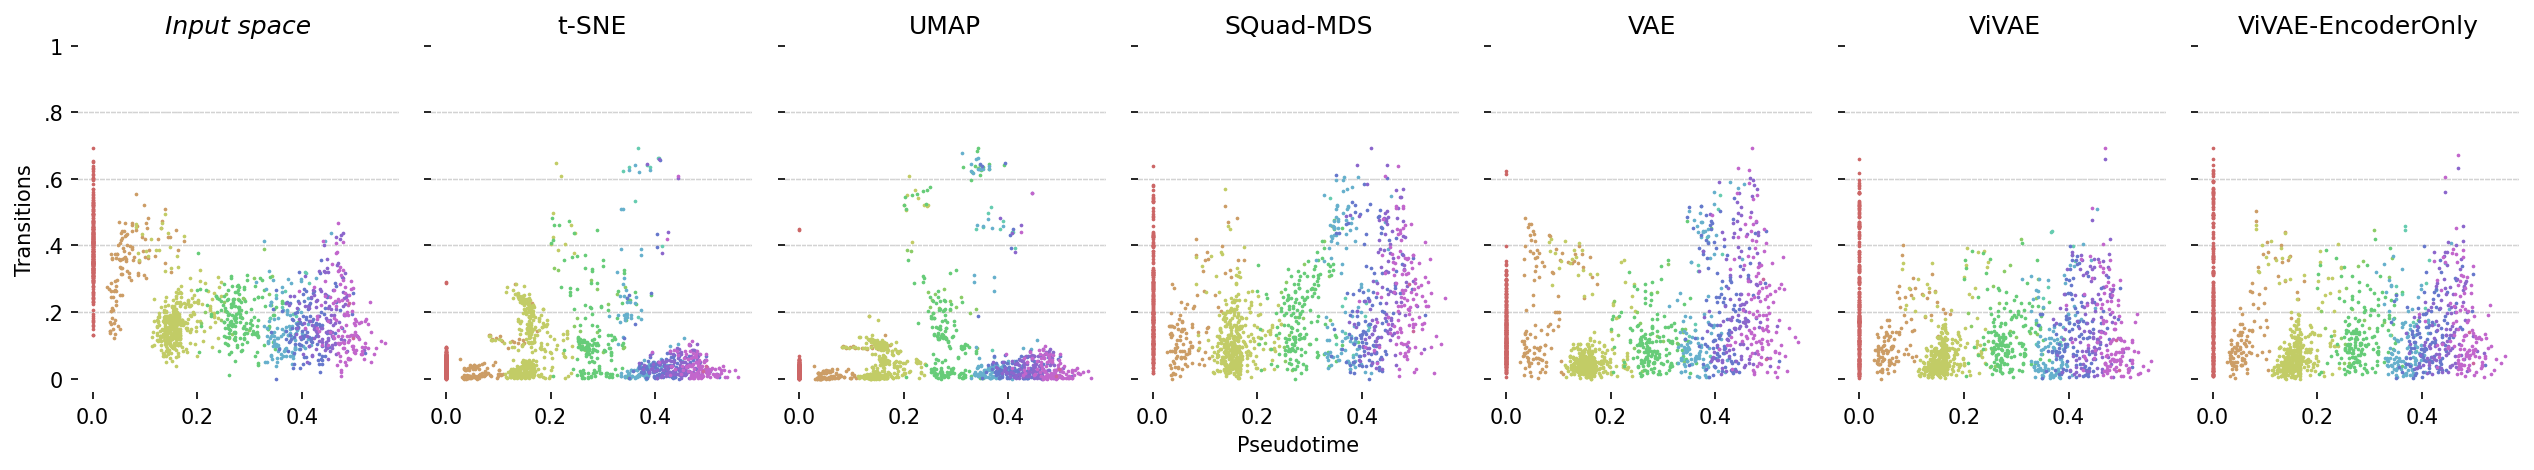

In [12]:
lin = 'Prechordal_Plate'
fig, ax = plot_transitions(
    all_td={lin: td[lin]},
    all_wd={lin: wd[lin]},
    all_which_best={lin: which_best[lin]},
    repre_names=['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly'],
    lineages=[lin],
    labs=labs,
    label_lineages=False,
    legend=False,
    fname='Farrell_transitions_example'
)

It remains to compute the $L^{1}$-norm error rates per lineage and embedding.
To give an overview, we plot these results in a heatmap...

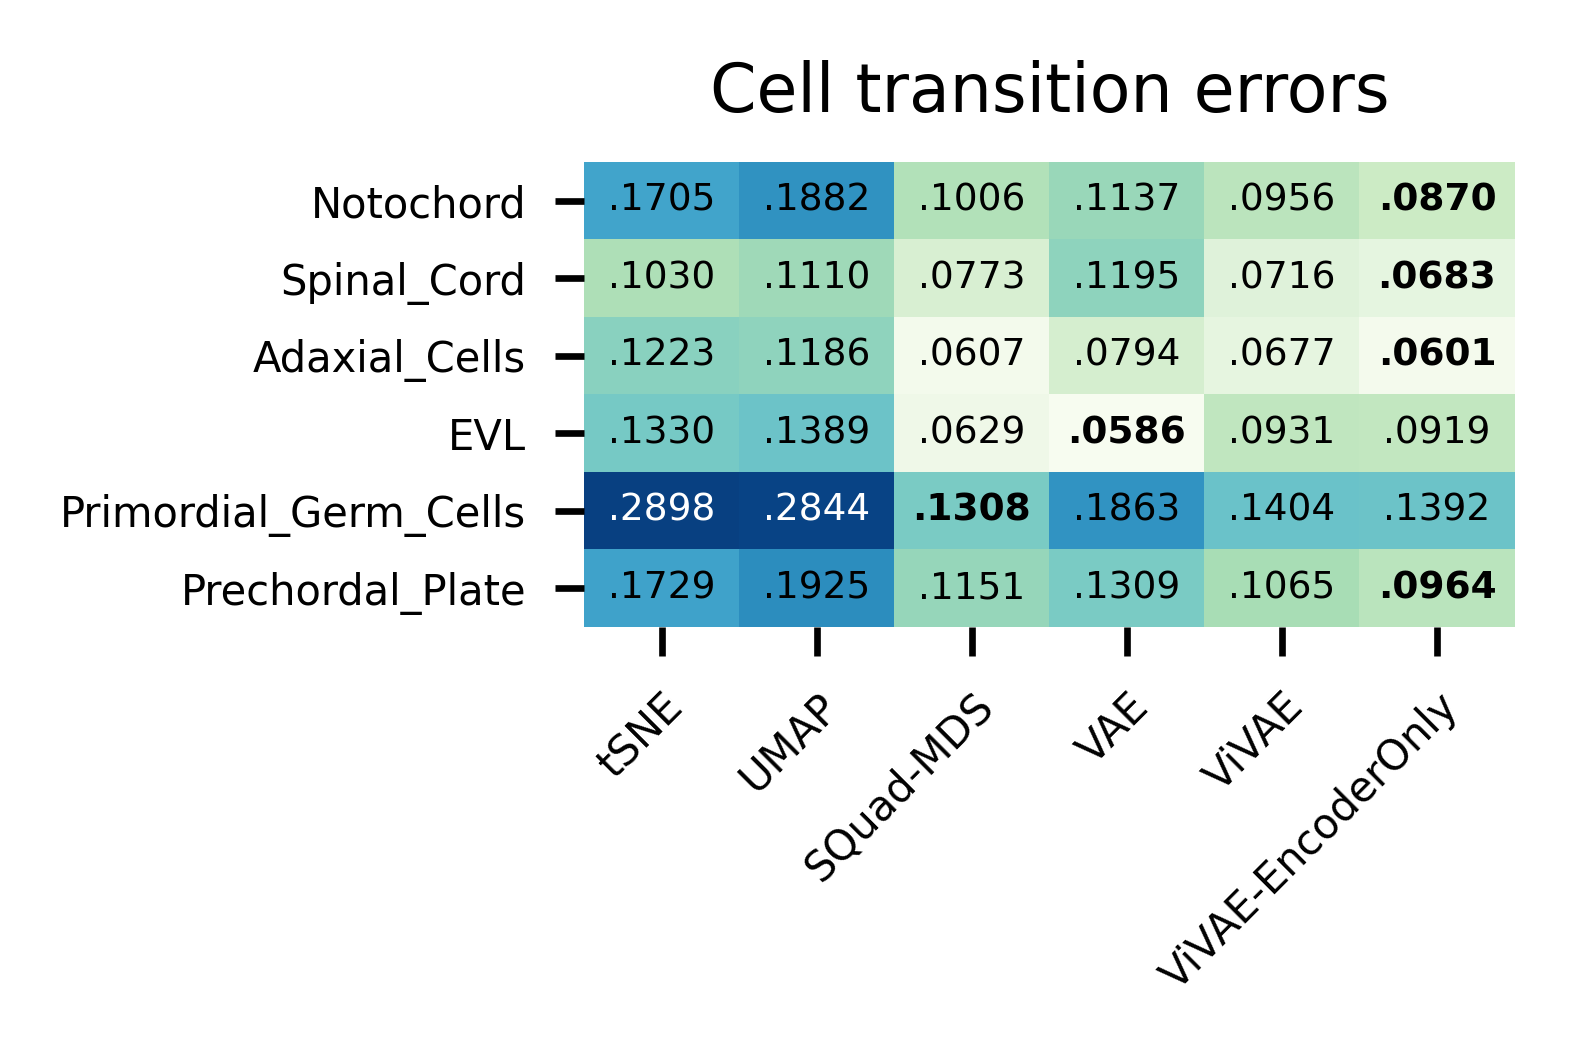

In [13]:
## Store results in a matrix for plotting the heatmap
wd_matrix = np.array([list(wd[lin].values())[1:] for lin in lineages])

## Compute number of cells in each lineage (for figure)
ls = [len(np.where([x in ['True', 'TRUE'] for x in meta[f'Lineage_{lin}'][1:]])[0]) for lin in lineages]

## Plot heatmap of results per lineage per embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), dpi=600)

## Initialise heatmap
im = ax.imshow(np.log10(wd_matrix), cmap='GnBu', aspect=.5)
ax.set_yticks(np.arange(len(lineages)), labels=cols, size=5)
ax.set_xticks(np.arange(len(methods)), labels=methods, size=5)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

for i in range(len(lineages)):
    vals = wd_matrix[i,:]
    
    ## Show error values and highlight best performer per lineage
    which_best = np.argmin(vals)
    for j in range(len(methods)):
        val = vals[j]
        weight = 'bold' if j==which_best else 'normal'
        color = 'black' if val<.2 else 'white'
        str_l1 = f'{("%.4f"%val).lstrip("0")}'
        text = ax.text(j, i, str_l1, ha='center', weight=weight, va='center', color=color, size=4.5)

ax.set_title('Cell transition errors', size=8)

## Save figures
fig.savefig(f'Farrell_errors_heatmap.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_errors_heatmap.svg', bbox_inches='tight', transparent=True)

## **5.** Compute and plot encoder indicatrices for VAE-based models

Let's demonstrate the **analysis of latent space distortions using encoder indicatrices**, as described in our paper, using this dataset.

We will begin by computing indicatrices for the entire embedding from each VAE-based model and plotting them.
Next, we will zoom in to inspect parts of the latent space where notable distortion is detected, and re-compute indicatrices on a higher-resolution grid to analyse these specific sections of the embeddings.

Our parameters used for computing and plotting the indicatrices, as well as coordinates for zooming in, **assume that PyTorch keeps things reproducible**.
If it does not, **you will probably not need to adjust the indicatrix parameters**, but **you may need to make adjustments to the zoom-in coordinates due to some stochasticity (*e.g.*, rotation of the embeddings)**.

<hr>

First let's compute the indicatrices...

In [23]:
ei_vae           = model_vae.encoder_indicatrices(X=pc, radius=1e-1, n_steps=28, n_polygon=500)
ei_vivae         = model_vivae.encoder_indicatrices(X=pc_d, radius=5e-1, n_steps=17, n_polygon=500)
ei_vivae_enconly = model_vivae_enconly.encoder_indicatrices(X=pc_d, radius=1e-1, n_steps=19, n_polygon=500)
# try and reflect difference in scales across embeddings in the `n_steps`
# !!! what matters is the shape distortion (ellipses) and the inconsistence in size of indicatrices--not the absolute sizes

Let's plot the full embeddings with indicatrices superimposed over them (and check whether the indicatrices are parametrised decently)...

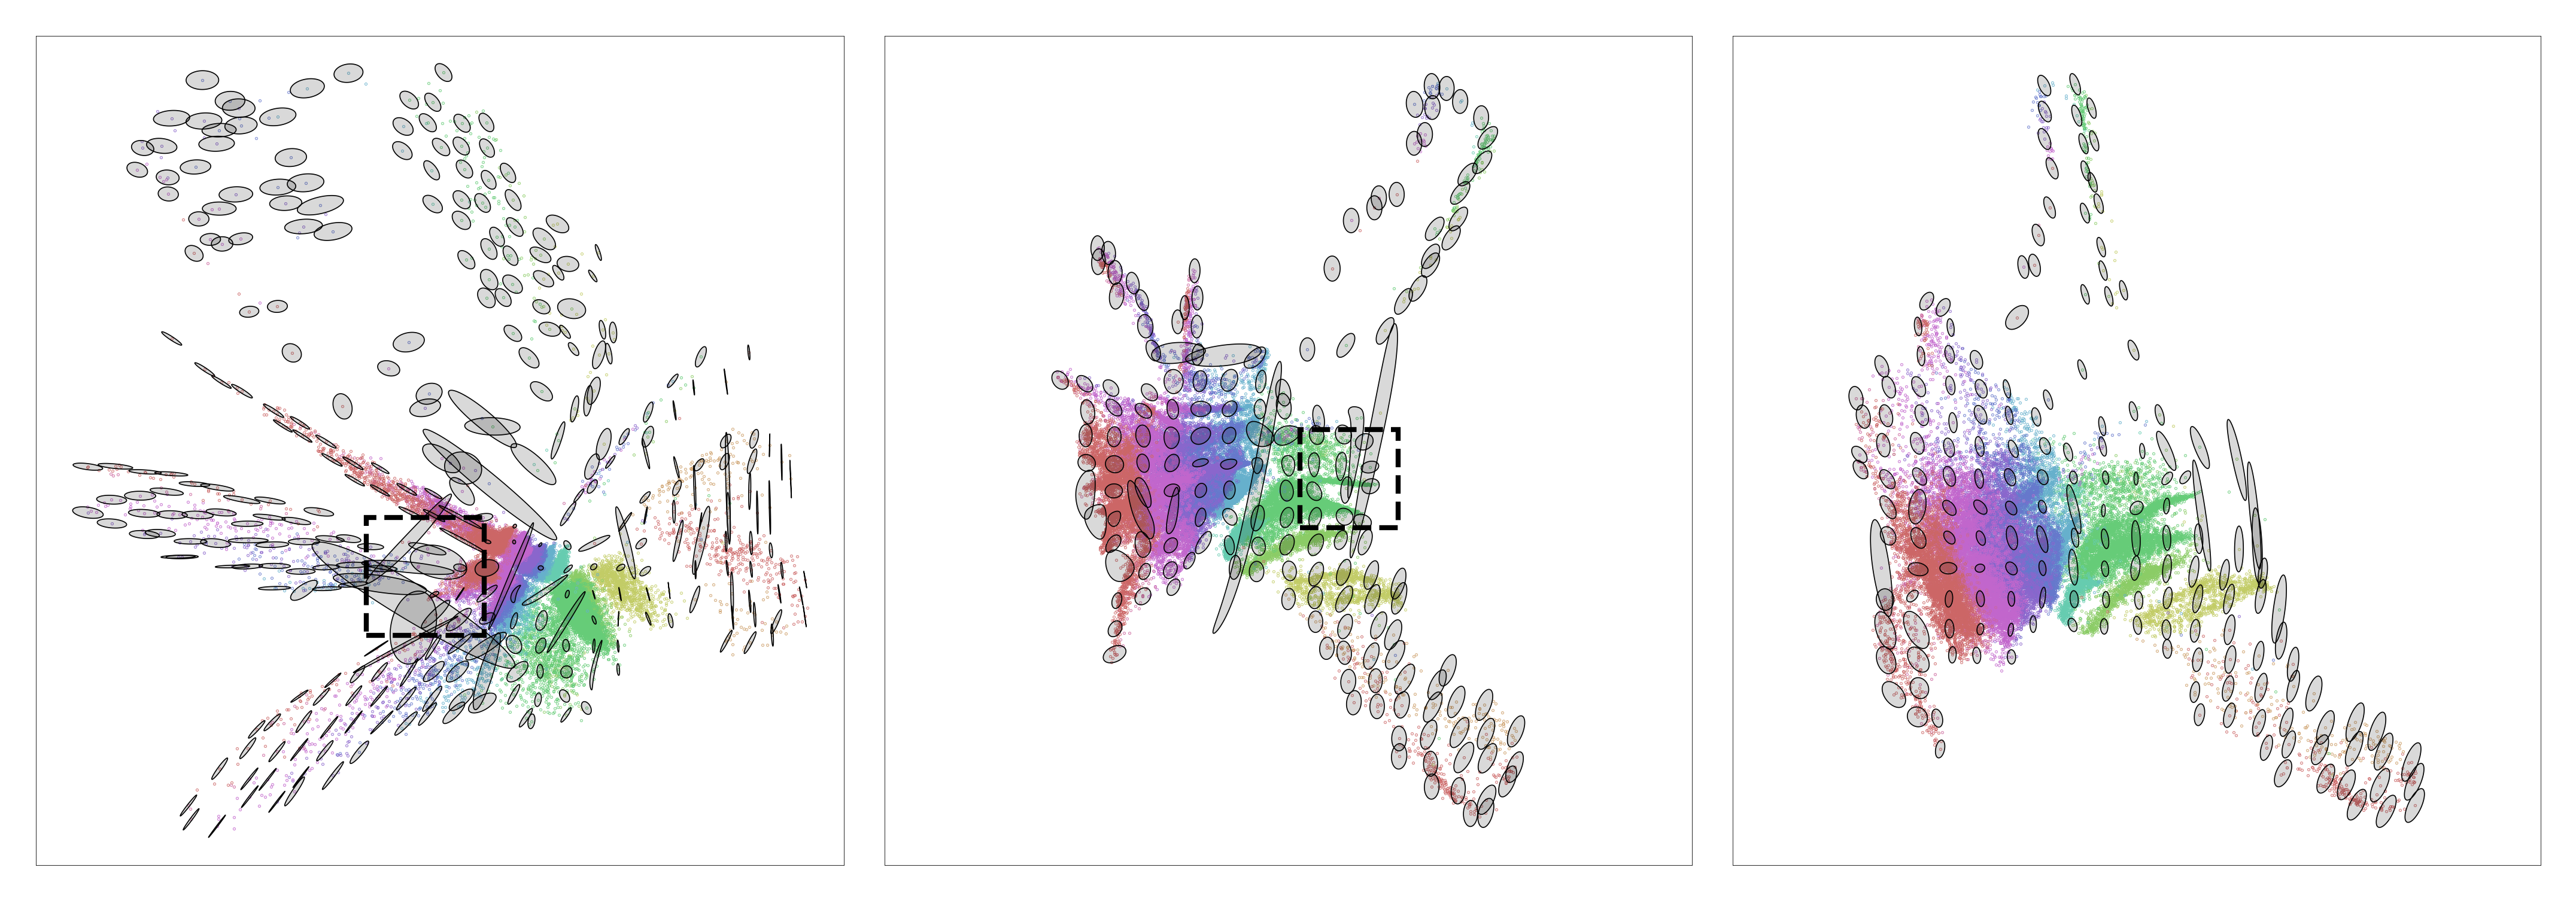

In [24]:
## Initialise a row of plots per VAE-based model
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), dpi=600)
fig.subplots_adjust(hspace=.05, wspace=.05)
handles = []
labels = []
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
embs = [emb_vae, emb_vivae, emb_vivae_enconly]
eis = [ei_vae, ei_vivae, ei_vivae_enconly]
subset_idcs = [None, None, None]

## Set scale factors: how big the indicatrices should be plotted
## ...absolute scale is arbitrary in these embeddings, this is merely to make the indicatrices easy to see
#sfs = [2e1, 3e0, 1e1]
sfs = [2e1, 3e0, 1e1]

## Inset specs: VAE and ViVAE each get a list of (1) coordinates of bottom-left corner of rectangle and (2) width and height of rectangle
## To be able to check the coordinates, comment out the line: `ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)`
vae_cutout   = [(-7,-3), (5,5)]
vivae_cutout = [(3.5, -2), (4,4)]

for i, method in enumerate(methods):
    si = subset_idcs[i]
    s = 2.
    if si is None:
        s = .01
        si = np.arange(len(labs))
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    
    ## Plot embeddings with hpf-stage labels
    for j, pop in enumerate(pops):
        idcs = np.where(labs[si]==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    ## Plot the zoom-in rectangle for VAE and ViVAE
    if method=='VAE':
        rect = Rectangle(xy=vae_cutout[0], width=vae_cutout[1][0], height=vae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)
    if method=='ViVAE':
        rect = Rectangle(xy=vivae_cutout[0], width=vivae_cutout[1][0], height=vivae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)

    ## Plot the indicatrices
    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.15])
    pol.set_linewidth(.2)
    pol.set_edgecolor('black')
    ax[i].add_collection(pol)

    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')

## Save zoomed-out figure    
fig.savefig('Farrell_indicatrices_zoomout.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_indicatrices_zoomout.svg', bbox_inches='tight', transparent=True)

Next, let's isolate the insets in the VAE and *ViVAE* embeddings, compute higher-resolution indicatrices for them and plot those...

In [25]:
## Get indices of points within each inset
idcs_vae_zoom = np.bitwise_and(
        np.bitwise_and(emb_vae[:,0]>= vae_cutout[0][0],                   emb_vae[:,1]>=vae_cutout[0][1]),
        np.bitwise_and(emb_vae[:,0]<=(vae_cutout[0][0]+vae_cutout[1][0]), emb_vae[:,1]<=vae_cutout[0][1]+vae_cutout[1][1])
    )
idcs_vivae_zoom = np.bitwise_and(
        np.bitwise_and(emb_vivae[:,0]>= vivae_cutout[0][0],                     emb_vivae[:,1]>=vivae_cutout[0][1]),
        np.bitwise_and(emb_vivae[:,0]<=(vivae_cutout[0][0]+vivae_cutout[1][0]), emb_vivae[:,1]<=vivae_cutout[0][1]+vivae_cutout[1][1])
    )

## Compute higher-resolution indicatrices
ei_vae_zoom   = model_vae.encoder_indicatrices(X=pc[idcs_vae_zoom], radius=5e-2, n_steps=28, n_polygon=500)
ei_vivae_zoom = model_vivae.encoder_indicatrices(X=pc_d[idcs_vivae_zoom], radius=1e-1, n_steps=19, n_polygon=500)

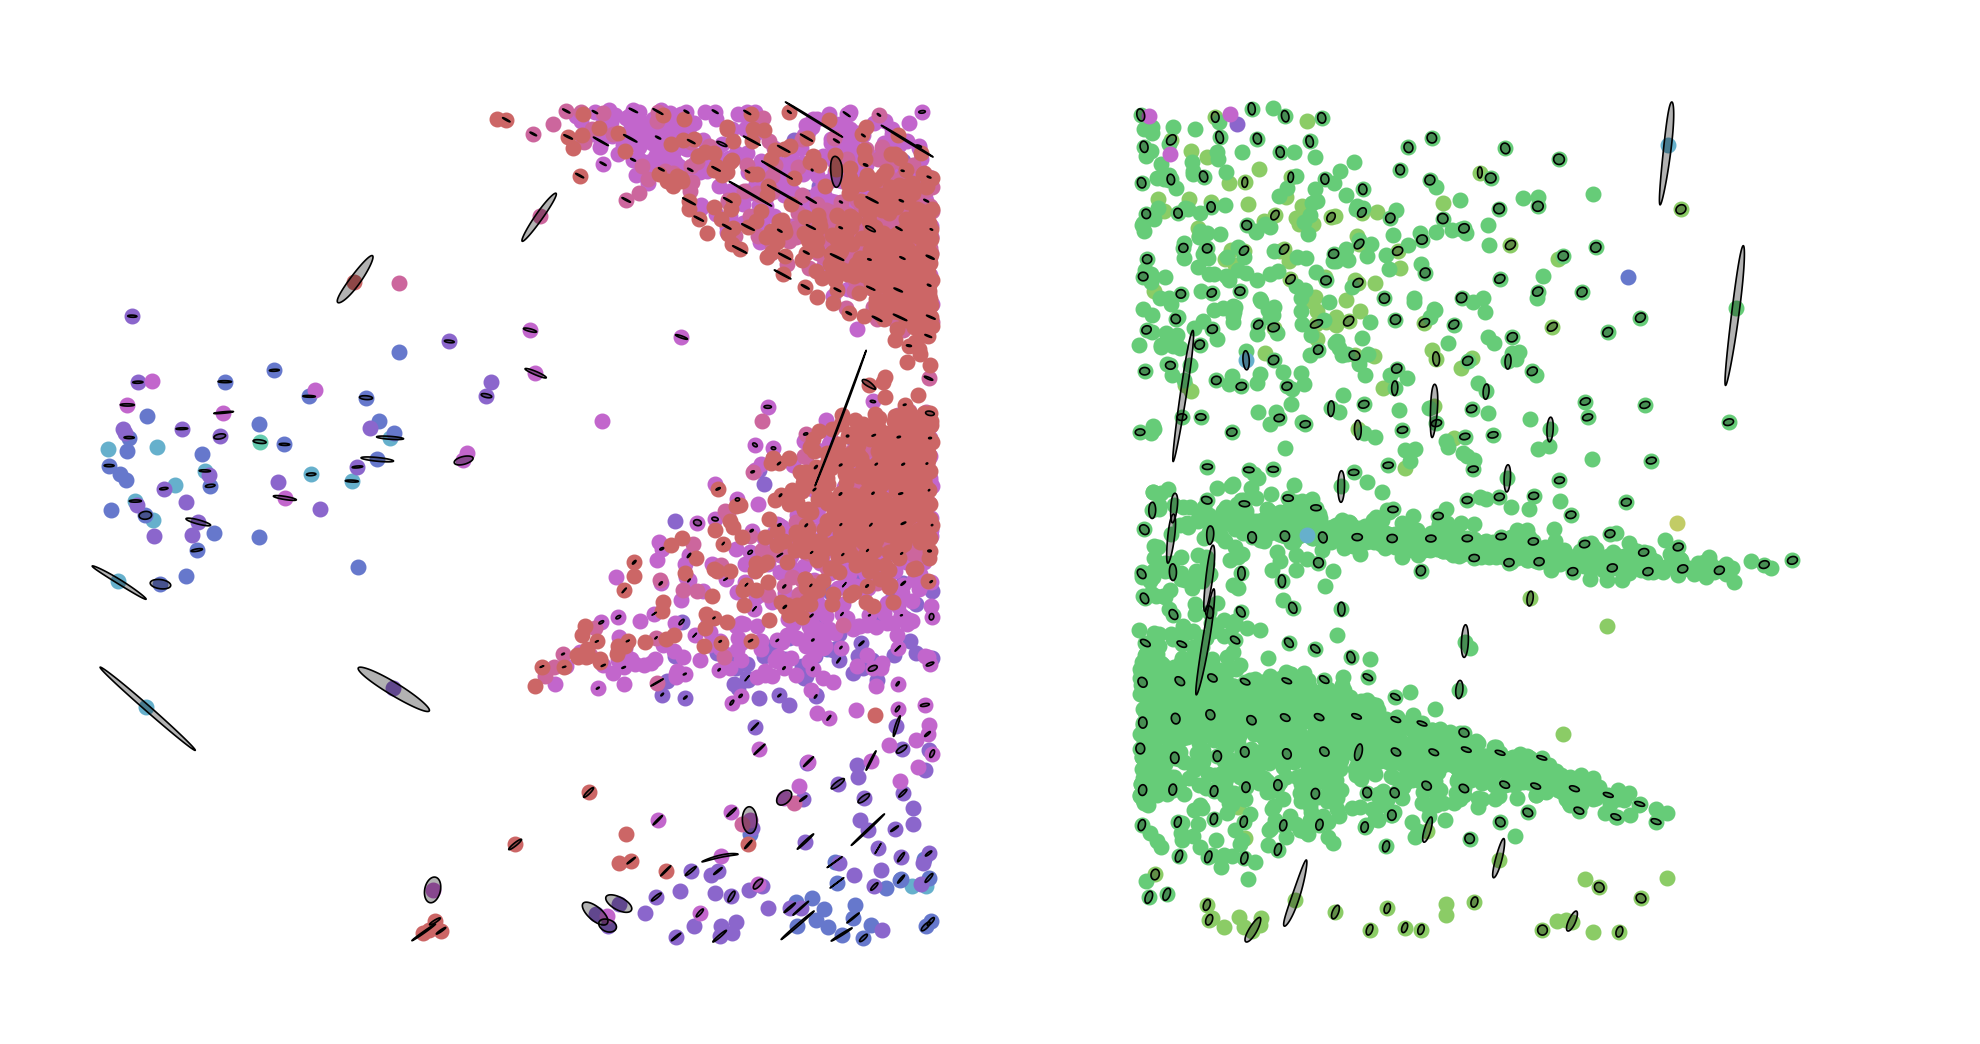

In [26]:
## Initialise a row of plots with zoom-in for VAE and ViVAE
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=600)
fig.subplots_adjust(hspace=.05, wspace=.05)
methods = ['VAE', 'ViVAE']
nmet = len(methods)
embs = [emb_vae[idcs_vae_zoom], emb_vivae[idcs_vivae_zoom]]
eis  = [ei_vae_zoom, ei_vivae_zoom]
ll   = [np.array(labs)[idcs_vae_zoom], np.array(labs)[idcs_vivae_zoom]]

## Scale factors: how big the indicatrices should be plotted
sfs = [2e0, 1e0]

for i, method in enumerate(methods):
    s = 2.
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    this_ll = ll[i]

    ## Plot embeddings with hpf-stage labels
    for j, pop in enumerate(pops):
        idcs = np.where(this_ll==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    ## Plot the indicatrices
    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])
    
    pol.set_linewidth(.2)
    pol.set_edgecolor('black')

    ax[i].add_collection(pol)

    ax[i].tick_params(axis='both', labelsize=5)
    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')
    ax[i].axis('off')
    
## Save figure
fig.savefig('Farrell_indicatrices_zoomin.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_indicatrices_zoomin.svg', bbox_inches='tight', transparent=True)

Our paper also contains an overview figure showing how indicatrices are computed.
We generate some illustrative plots that are part of that figure...

* The first plot shows a **grid of points** sampled from the embedding.
This is done to **trace these coordinates back** to their counterparts in input space.

* The second plot shows the corresponding indicatrices, capturing local distortions that occur when **we run coordinates sampled from the horizontal tangent space of each input-space point through the trained encoder model**.

In [27]:
## Set parameters for indicatrices
radius = 1e-1
n_steps = 12
n_polygon = 500
scale_factor = 12e0

## Compute gridpoint indices
ref = torch.tensor(emb_vivae)
xmin, xmax = torch.min(ref[:,0]).item(), torch.max(ref[:,0]).item()
ymin, ymax = torch.min(ref[:,1]).item(), torch.max(ref[:,1]).item()
nsteps_x = n_steps
nsteps_y = math.ceil((ymax-ymin)/(xmax-xmin)*nsteps_x)
stepsize_x = (xmax-xmin)/(nsteps_x)
stepsize_y = (ymax-ymin)/(nsteps_y)
stepsize = min(stepsize_x, stepsize_y)
xs = torch.linspace(xmin, xmax, steps=nsteps_x)
ys = torch.linspace(ymin, ymax, steps=nsteps_y)
g_idcs = vv.geometry.EncoderIndicatome.gridpoint_idcs(ref=ref, xgrid=xs, ygrid=ys)

## Trace back to ambient space
xr = torch.tensor(pc_d[g_idcs])
zr = model_vivae.net.submersion(xr)

## Compute Jacobian matrices
jac = torch.func.vmap(torch.func.jacfwd(model_vivae.net.submersion), in_dims=(0,))(xr)

## Find horizontal tangents
_, _, v = torch.svd(jac, some=False)
htv = v[:, :2]

## Create indicatrices in ambient space
xp = []
for i in range(xr.shape[0]):
    origin = xr[i]
    t1 = htv[i,0,:] # horizontal tangent vector 1
    t2 = htv[i,1,:] # horizontal tangent vector 1
    circle = vv.geometry.EncoderIndicatome.circle_on_2manifold(origin, t1, t2, radius, n_polygon)
    xp.append(circle)

## Submerge and scale indicatrices
zp = [model_vivae.net.submersion(this_xp) for this_xp in xp]
zp_scaled = []
for i in range(zr.shape[0]):
    res = vv.geometry.EncoderIndicatome.scale_ellipse(zp[i], zr[i], scale_factor, False)
    zp_scaled.append(res)

## Generate polygon patches
polygons = [Polygon(tuple(vec.tolist()), closed=True) for vec in zp_scaled]
pol = PatchCollection(polygons)
pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])

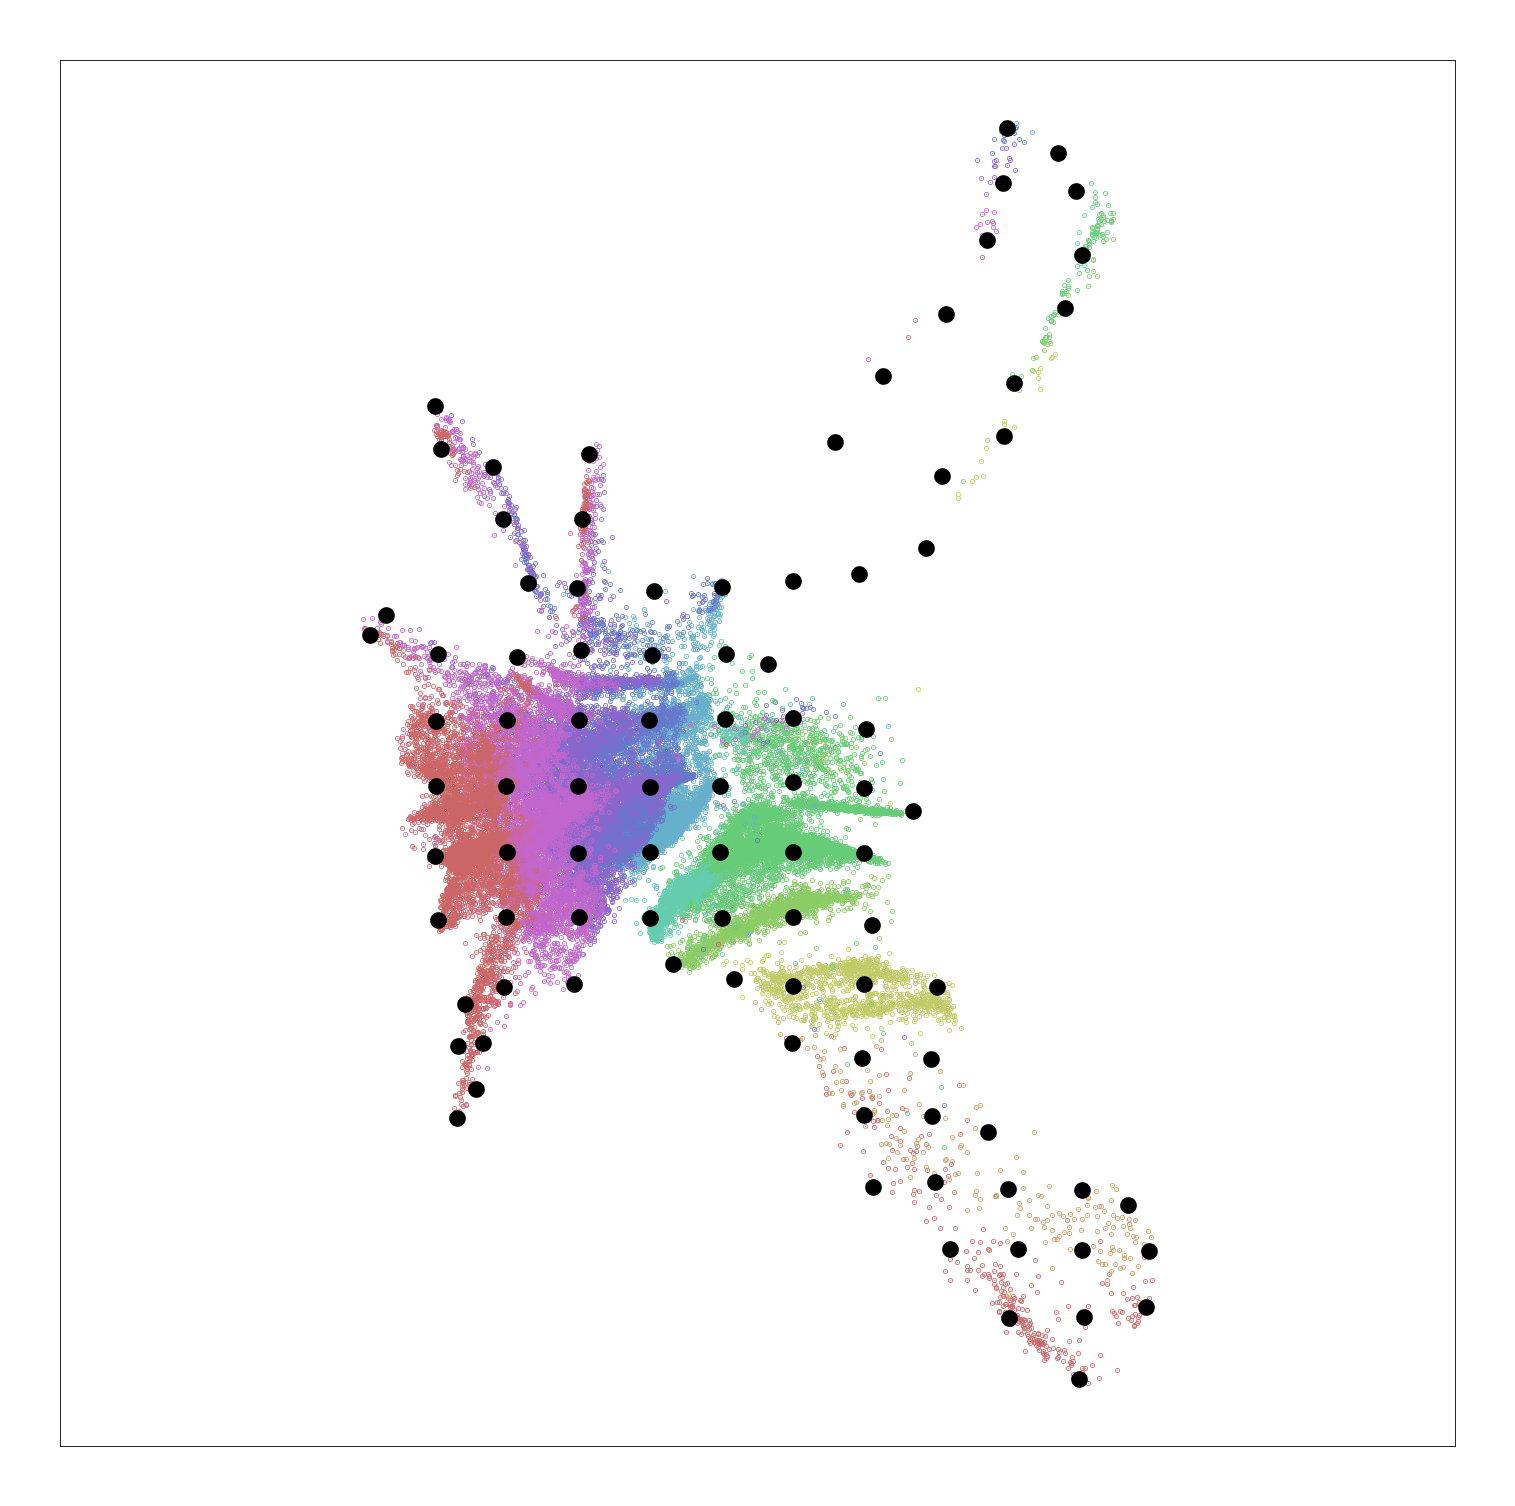

In [28]:
## SCHEMATIC PLOT 1

## Initialise plot
fig, ax = plt.subplots(figsize=(3,3), dpi=600)

## Plot cells labelled by hpf stage
for j, pop in enumerate(pops):
    idcs = np.where(labs==pop)[0]
    if i==0:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, label=pop, c=palette[j], alpha=1., linewidth=.5)
    else:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, c=palette[j], alpha=1., linewidth=.5)

## Mark the grid-sampled points
ax.scatter(emb_vivae[g_idcs,0], emb_vivae[g_idcs,1], s=1., label=pop, c='black', alpha=1., linewidth=1.)

ax.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax.axis('equal')

## Save plot
fig.savefig(f'Farrell_schematic_1.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_schematic_1.svg', bbox_inches='tight', transparent=True)

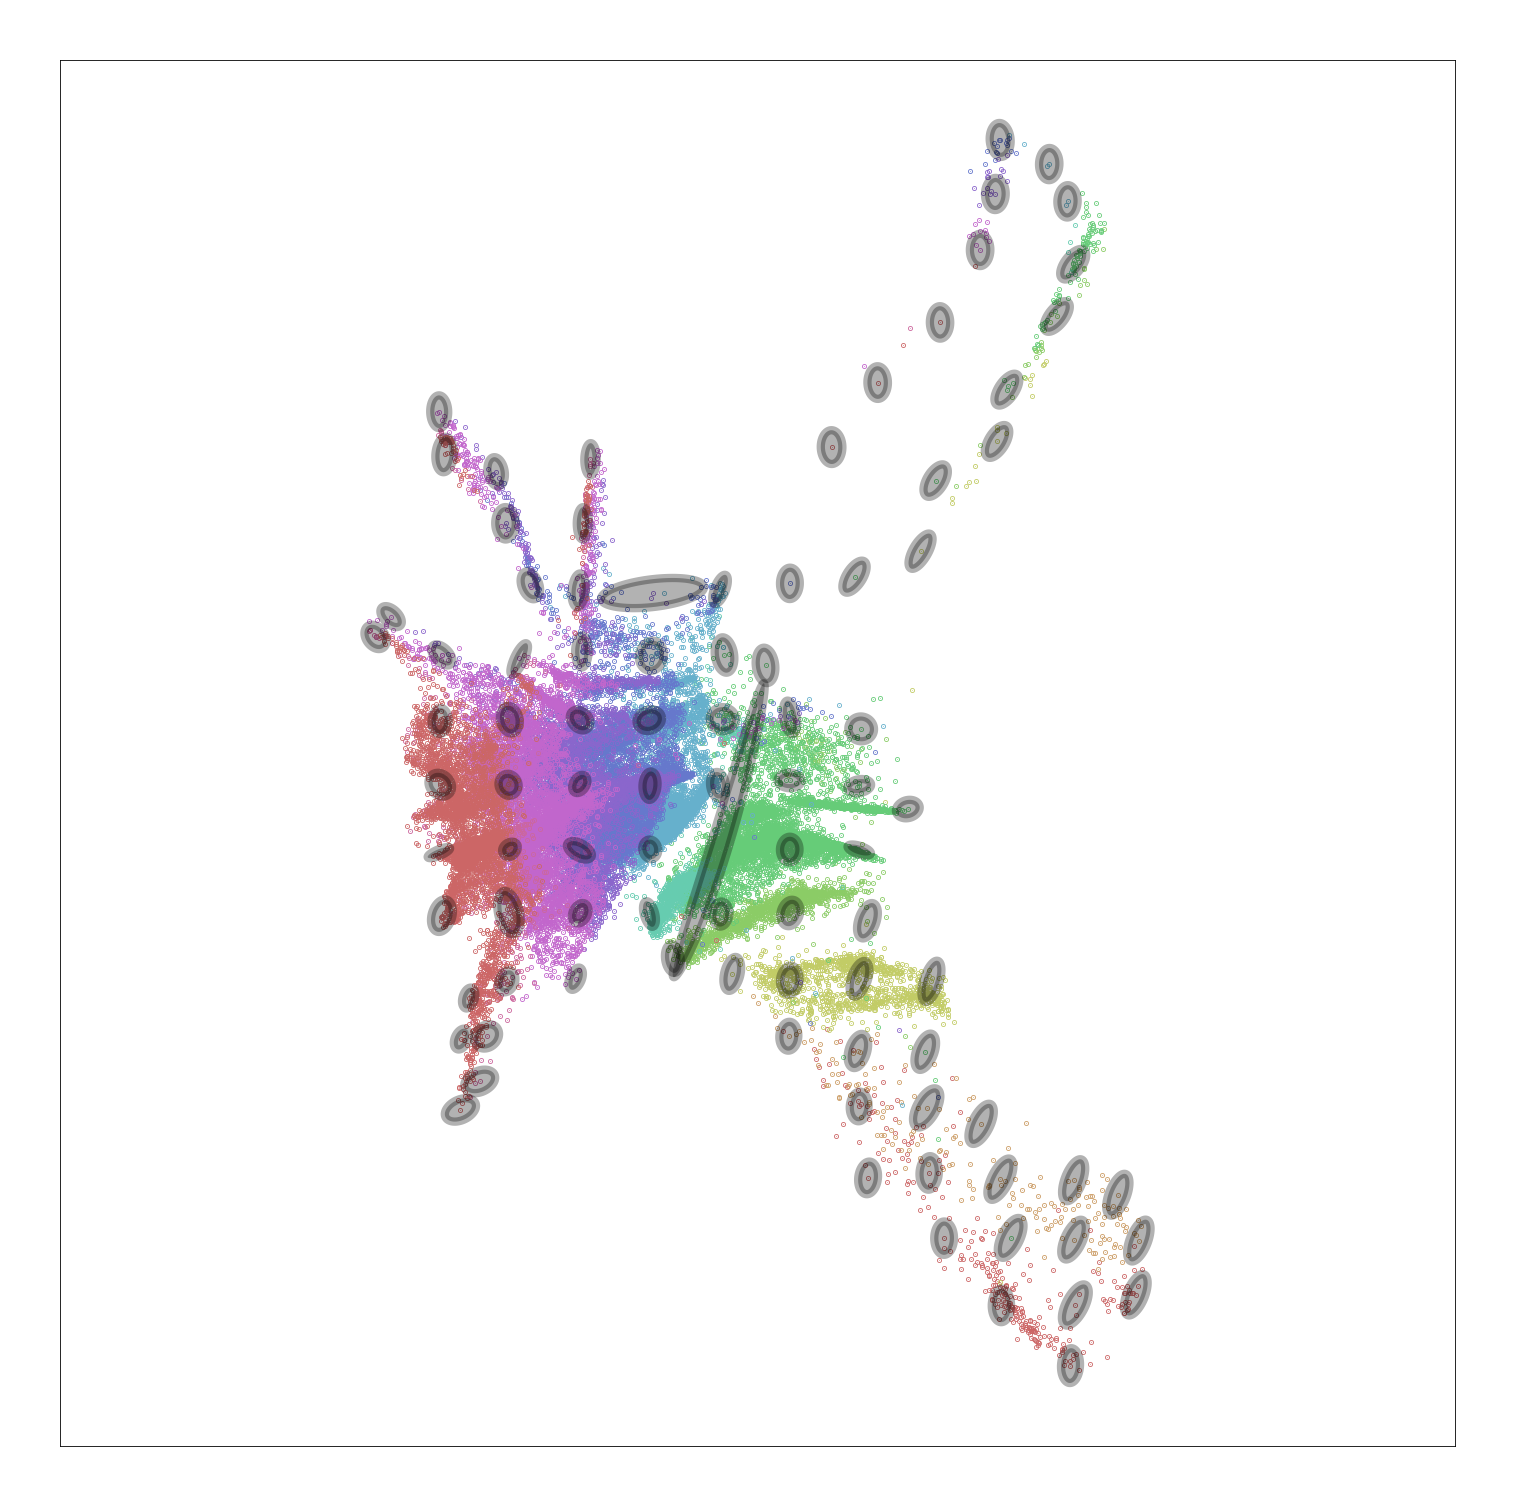

In [29]:
## SCHEMATIC PLOT 2

## Initialise plot
fig, ax = plt.subplots(figsize=(3,3), dpi=600)

## Plot cells labelled by hpf stage
for j, pop in enumerate(pops):
    idcs = np.where(labs==pop)[0]
    if i==0:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, label=pop, c=palette[j], alpha=1., linewidth=.5)
    else:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, c=palette[j], alpha=1., linewidth=.5)

## Plot indicatrices
ax.add_collection(pol)

ax.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax.axis('equal')

## Save plot
fig.savefig(f'Farrell_schematic_2.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_schematic_2.svg', bbox_inches='tight', transparent=True)

## **7.** Compute xNPE for the *06.0-SHIELD* stage

There is a notable difference in the relative position of the *06.0-SHIELD* cell between the cluster-forming and smooth embeddings.

For an *ad hoc* validation of the clearer placement along the developmental gradient by MDS- and VAE-based models, we compute **xNPE scores** (as defined in our paper).

In [30]:
## Check if xNPEs already computed
res_exist = np.sum([
        not os.path.exists(f'xnpe_{m}.npy')
        for m in ['tsne', 'umap', 'squadmds', 'vae', 'vivae', 'vivae_enconly']
    ])==0

## If not, compute and save them
if not res_exist:
    xnpe_tsne          = vs.xnpe(hd=pc, ld=emb_tsne, annot=labs, knn=knn,          random_state=1)
    xnpe_umap          = vs.xnpe(hd=pc, ld=emb_umap, annot=labs, knn=knn,          random_state=1)
    xnpe_squadmds      = vs.xnpe(hd=pc, ld=emb_squadmds, annot=labs, knn=knn,      random_state=1)
    xnpe_vae           = vs.xnpe(hd=pc, ld=emb_vae,      annot=labs, knn=knn,      random_state=1)
    xnpe_vivae         = vs.xnpe(hd=pc, ld=emb_vivae, annot=labs, knn=knn,         random_state=1)
    xnpe_vivae_enconly = vs.xnpe(hd=pc, ld=emb_vivae_enconly, annot=labs, knn=knn, random_state=1)
    np.save('xnpe_tsne.npy', xnpe_tsne, allow_pickle=True)
    np.save('xnpe_umap.npy', xnpe_umap, allow_pickle=True)
    np.save('xnpe_squadmds.npy', xnpe_squadmds, allow_pickle=True)
    np.save('xnpe_vae.npy', xnpe_vae, allow_pickle=True)
    np.save('xnpe_vivae.npy', xnpe_vivae, allow_pickle=True)
    np.save('xnpe_vivae_enconly.npy', xnpe_vivae_enconly, allow_pickle=True)
else:
    xnpe_tsne          = np.load('xnpe_tsne.npy', allow_pickle=True).item()
    xnpe_umap          = np.load('xnpe_umap.npy', allow_pickle=True).item()
    xnpe_squadmds      = np.load('xnpe_squadmds.npy', allow_pickle=True).item()
    xnpe_vae           = np.load('xnpe_vae.npy', allow_pickle=True).item()
    xnpe_vivae         = np.load('xnpe_vivae.npy', allow_pickle=True).item()
    xnpe_vivae_enconly = np.load('xnpe_vivae_enconly.npy', allow_pickle=True).item()

In [31]:
## Set population of interest
poi = '06.0-SHIELD' 
digits = 3 # for rounding

print(f"""xNPE of {poi}
    t-SNE:         {xnpe_tsne[poi]:.{digits}f}
    UMAP:          {xnpe_umap[poi]:.{digits}f}
    SQuad-MDS:     {xnpe_squadmds[poi]:.{digits}f}
    VAE:           {xnpe_vae[poi]:.{digits}f}
    ViVAE:         {xnpe_vivae[poi]:.{digits}f}
    ViVAE-EncOnly: {xnpe_vivae_enconly[poi]:.{digits}f}
""")

xNPE of 06.0-SHIELD
    t-SNE:         0.782
    UMAP:          0.858
    SQuad-MDS:     0.620
    VAE:           0.162
    ViVAE:         0.153
    ViVAE-EncOnly: 0.149



## **8.** Exploratory single-cell analysis via differential gene expression

DR algorithms are key in **exploring single-cell data to identify structures of interest**.

Clasically, this includes the **discovery of candidate sub-populations or outlier cell subsets** where an embedding shows a separation.

In addition to this, an unsupervised DR approach can help **detect candidate endpoints of developmental pathways**: note that the *ViVAE* embedding manages to separate early progenitors as well as some pathway endpoints despite not using any prior information about trajectories.

Finally, low-dimensional embeddings of developmental data like this can identify **previously unlabelled branching of lineages**.
We show a small example here, using the *NANOS3* gene expression extracted earlier: we identify *NANOS3* as a marker distinguishing between two branches of the primordial germ cell lineage...

Text(0.5, 1.0, 'Expression of NANOS3 in Primordial_Germ_Cells')

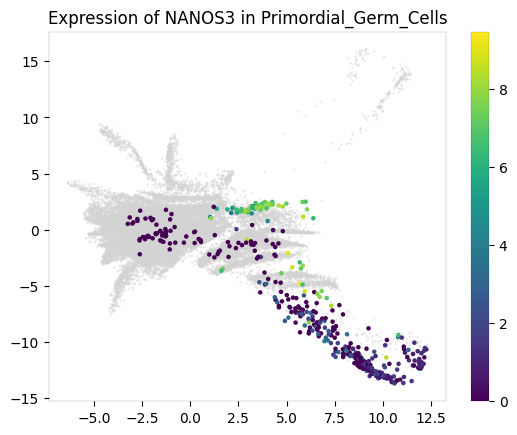

In [33]:
emb = emb_vivae
lin = 'Primordial_Germ_Cells'
gene = 'NANOS3'
e = np.load(f'./Farrell_exprs_{gene}.npy', allow_pickle=True)
lin_idcs = cell_idcs[lin]
plt.scatter(emb[:,0], emb[:,1], s=.1, c='lightgrey')
plt.scatter(emb[lin_idcs,0], emb[lin_idcs,1], s=5., c=e[lin_idcs])
plt.colorbar()
plt.title(f'Expression of {gene} in {lin}')

To discover genetic markers for structures that are revealed by a low-dimensional embedding:

* select the indices of cells within a subset of interest in the embedding (see, for instance, the code for defining inset boundaries in *Section 5*);
* select the indices of cells against which the subset of interest should be compared (*e.g.*, all other cells or remaining cells within a lineage);
* load the corresponding gene expression data using `scanpy` (in Python) or `Seurat` (in R);
* use `scanpy.tl.rank_genes_groups` or `Seurat::FindMarkers` to perform a differential expression analysis between the 2 groups.